# Build a model to predict performance of employees, based on the visualisation and analysis of past data of employee performance

## Task 1: Reading your data into a Dataframe

# Requried libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

# Data

In [2]:
data= pd.read_csv(r"C:\Users\Admin\Downloads\Test_data.csv") # Import the data in the form of csv

In [3]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [5]:
data.describe() #Describe the data

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,23490.000000,23490.000000,23490.000000,21678.000000,23490.000000,23490.000000,23490.000000,23490.000000
mean,39041.399149,1.254236,34.782929,3.339146,5.810387,0.358834,0.022776,63.263133
std,22640.809201,0.600910,7.679492,1.263294,4.207917,0.479668,0.149191,13.411750
min,3.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,19370.250000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,38963.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,58690.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,78295.000000,9.000000,60.000000,5.000000,34.000000,1.000000,1.000000,99.000000


In [6]:
nan_counts = data.isnull().sum() # Find and count null values

nan_counts

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

## Task 2: Data Cleaning
**Data cleaning is the process of preparing data for analysis by removing or modifying data that is incorrect, incomplete, irrelevant, duplicated, or improperly formatted.**

**In this task, you can execute the below steps & proceed further**

*-Treat NULL Values (if any)*

*-Remove duplicate data / check all the columns and look for the useful metrics which can be employed in the model*


**Find corelation for filling the null values in "education" and "previous_year_rating" columns**

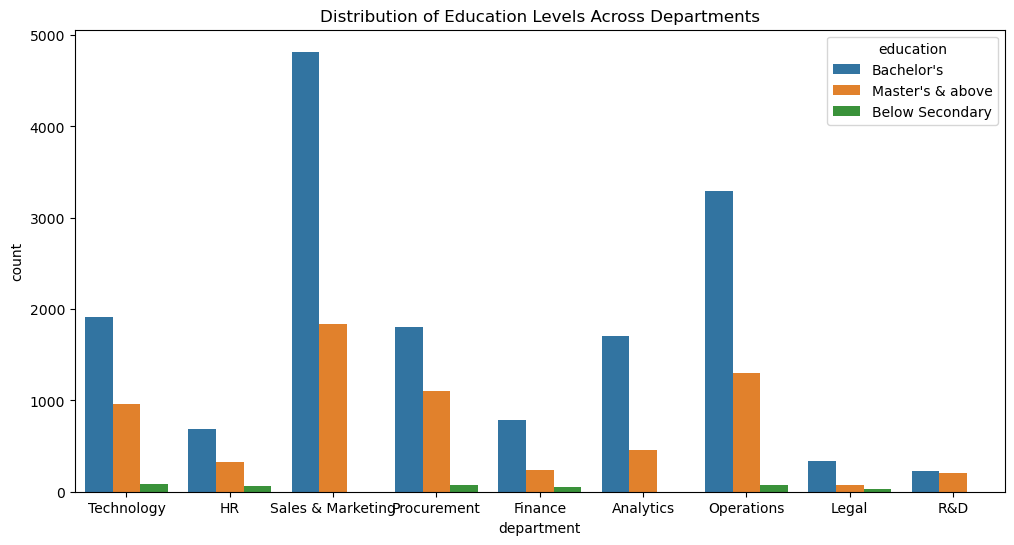

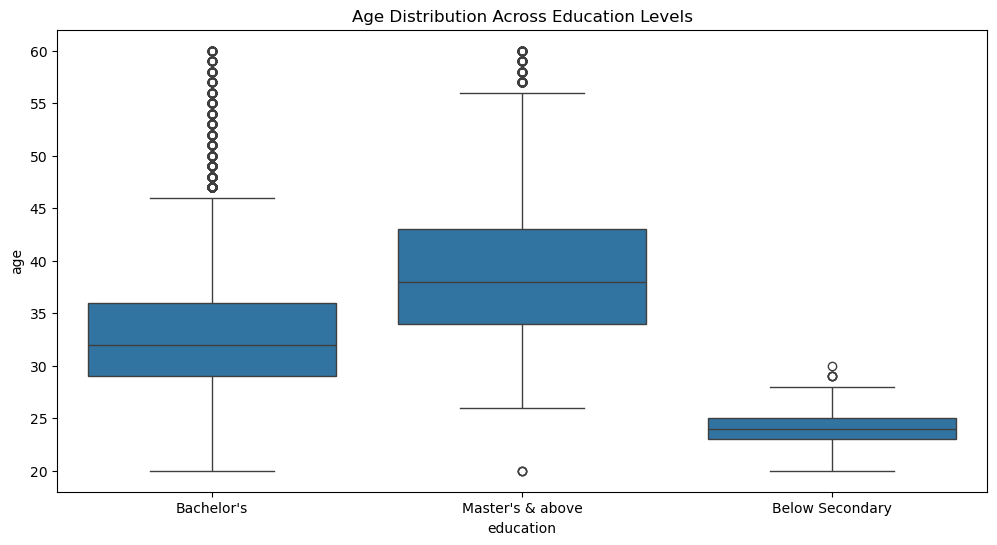

In [7]:
# Department vs. Education
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='department', hue='education')
plt.title('Distribution of Education Levels Across Departments')
plt.show()

# Age vs. Education
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='education', y='age')
plt.title('Age Distribution Across Education Levels')
plt.show()



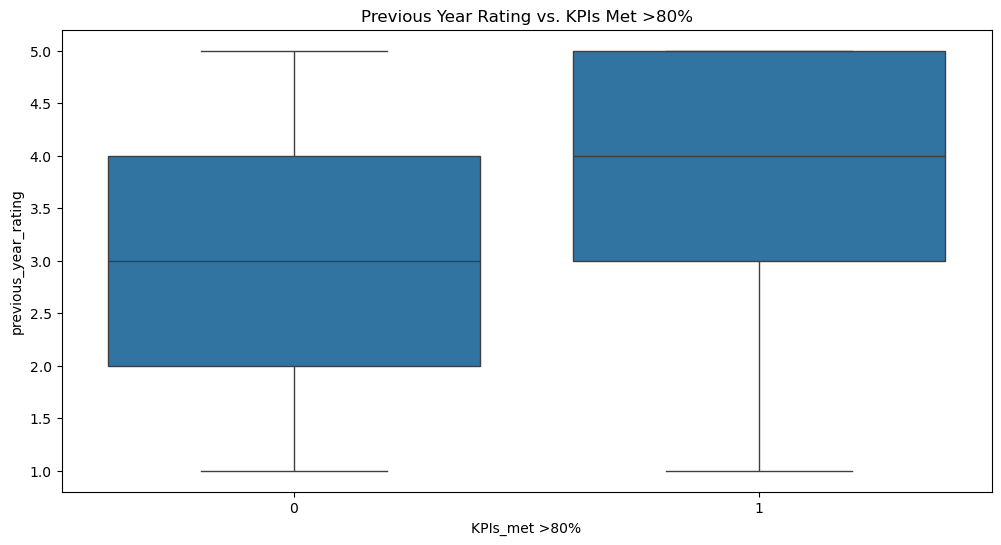

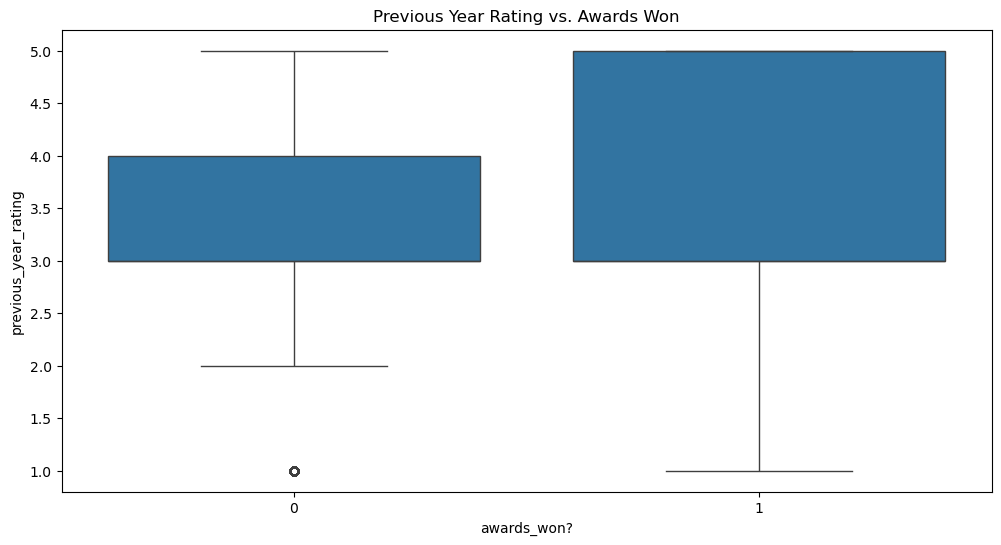

In [8]:
# KPIs_met >80% vs. Previous Year Rating
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='KPIs_met >80%', y='previous_year_rating')
plt.title('Previous Year Rating vs. KPIs Met >80%')
plt.show()

# Awards Won vs. Previous Year Rating
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='awards_won?', y='previous_year_rating')
plt.title('Previous Year Rating vs. Awards Won')
plt.show()




# Fill null values

In [9]:
# Create a combined feature of 'age' and 'department'
data['age_department'] = data['age'].astype(str) + '_' + data['department']

# Fill missing values in 'education' based on the most frequent value in the corresponding 'age_department'
data['education'] = data.groupby('age_department')['education'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))


In [10]:
# Create a combined feature of 'awards_won' and 'KPIs_met >80%'
data['awards_kpis'] = data['awards_won?'].astype(str) + '_' + data['KPIs_met >80%'].astype(str)

# Fill missing values in 'previous_year_rating' based on the most frequent value in the corresponding 'awards_kpis'
data['previous_year_rating'] = data.groupby('awards_kpis')['previous_year_rating'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x.mean()))

# Drop the temporary 'awards_kpis' column
data = data.drop(columns=['awards_kpis'])

# Save the processed data
data.to_csv('employee_performance_filled.csv', index=False)


In [11]:
nan_counts = data.isnull().sum()
# again see the any null value are remain or not
    
nan_counts

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
age_department          0
dtype: int64

**Find and remove duplicate rows**

In [12]:
# Display basic information and check for duplicates
data.info()
print("Number of duplicate rows:", data.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             23490 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  23490 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
 13  age_department        23490 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 2.5+ MB
Number of dup

In [13]:
# Check data types
data.dtypes.describe()

count        14
unique        3
top       int64
freq          7
dtype: object

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
label_encoders = {}
categorical_columns = ['department', 'region', 'education', 'gender', 'recruitment_channel']

for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Feature scaling
scaler = StandardScaler()
scaled_columns = ['age', 'length_of_service', 'avg_training_score']
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Display the processed data
data


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,age_department
0,8724,8,18,0,1,2,1,-1.404150,5.0,-1.143200,1,0,1.024263,24_Technology
1,74430,2,28,0,0,0,1,-0.492612,3.0,-0.192590,0,0,-0.914377,31_HR
2,72255,7,4,0,1,0,1,-0.492612,1.0,-0.430243,0,0,-1.212629,31_Sales & Marketing
3,38562,5,11,0,0,0,3,-0.492612,2.0,0.758019,0,0,0.129506,31_Procurement
4,64486,1,21,0,1,2,1,-0.622832,4.0,0.282714,0,0,-0.168746,30_Finance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,3,11,1,1,2,1,-1.404150,3.0,-1.143200,0,0,-0.168746,24_Legal
23486,25600,8,17,0,1,2,1,-0.492612,3.0,0.282714,0,0,0.800574,31_Technology
23487,45409,2,7,0,0,2,1,-1.143711,4.0,-0.430243,0,0,-0.988940,26_HR
23488,1186,5,24,0,1,2,3,-1.013491,3.0,-1.143200,0,0,0.502321,27_Procurement


## Task 3: Visualization
**Data visualization is the graphical representation of information and data. By using visual elements like charts, graphs, and maps, data visualization tools provide an accessible way to see and understand trends, outliers, and patterns in data.**

**In this task, you must execute the below steps:**

*-Use Charts (Count plots) to examine and compare the features present in the dataset*

*-Identify trends and insights from the above plots*

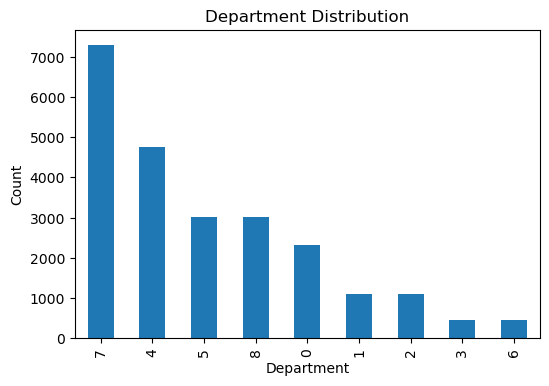

In [15]:
plt.figure(figsize=(6,4))
data['department'].value_counts().plot(kind='bar')
plt.title('Department Distribution')
plt.xlabel('Department')
plt.ylabel('Count')
plt.show()


1. Department Distribution

- One department dominates headcount → this is a structural imbalance, not noise. Any model will overfit to this department’s patterns.
- Several departments are severely underrepresented → predictions for them will be weak and unreliable unless handled explicitly.
- Business implication: Promotions or performance drivers learned here mostly reflect the dominant department, not the org as a whole.

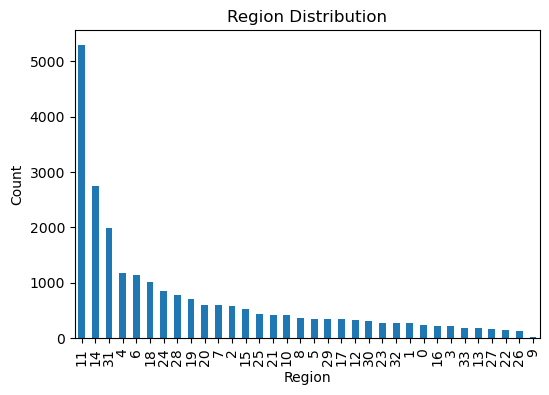

In [16]:
plt.figure(figsize=(6,4))
data['region'].value_counts().plot(kind='bar')
plt.title('Region Distribution')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()


2. Region Distribution

- Highly skewed geographic spread → a handful of regions contribute most employees.
- Long tail of low-volume regions → statistically fragile; don’t overinterpret trends there.
- Modeling risk: Region becomes a proxy for data availability, not true performance differences.

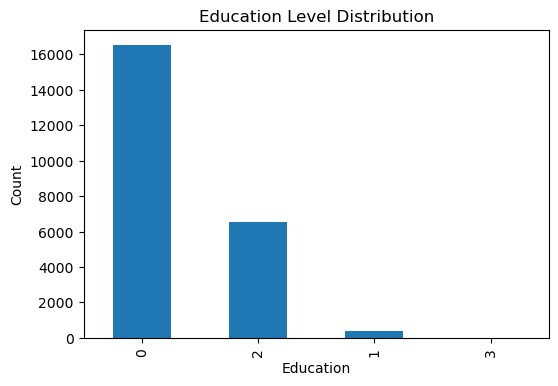

In [17]:
plt.figure(figsize=(6,4))
data['education'].value_counts().plot(kind='bar')
plt.title('Education Level Distribution')
plt.xlabel('Education')
plt.ylabel('Count')
plt.show()


3. Education Level Distribution

- Education level “0” overwhelmingly dominates → education is not a differentiator for most employees.
- Higher education levels are rare → weak signal, limited predictive power.
-  Hard truth: Education will not drive promotions meaningfully unless interaction effects are explored.

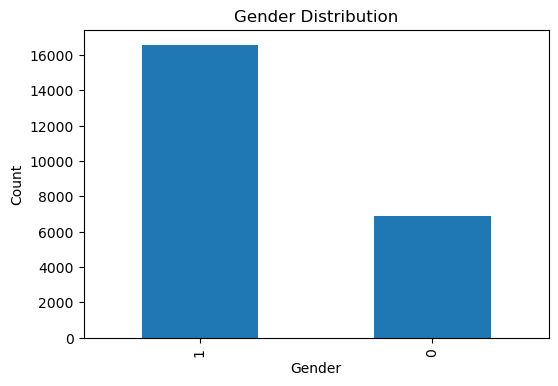

In [18]:
plt.figure(figsize=(6,4))
data['gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


4. Gender Distribution

- Clear gender imbalance → majority class dominates outcomes.
- Any accuracy metric without fairness checks is misleading.
- If you don’t address this, your model will silently favor the majority gender. Period.

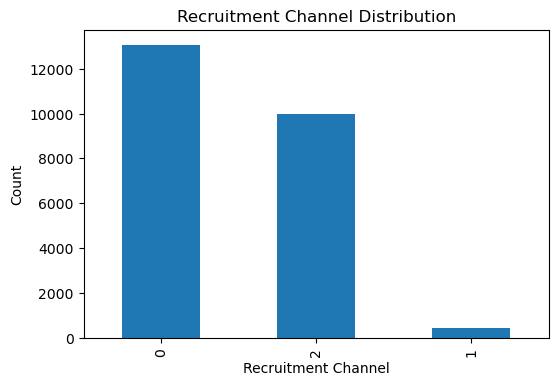

In [19]:
plt.figure(figsize=(6,4))
data['recruitment_channel'].value_counts().plot(kind='bar')
plt.title('Recruitment Channel Distribution')
plt.xlabel('Recruitment Channel')
plt.ylabel('Count')
plt.show()


5. Recruitment Channel Distribution

- Two channels account for almost all hiring → internal consistency, but low diversity.
- One channel is nearly irrelevant → drop it or bin it.
- Actionable insight: Recruitment channel may correlate with promotion simply due to volume, not quality.

## Task 4: Data Scaling
**Scaling is a technique to standardize the independent features present in the data in a fixed range. It is performed during the data pre-processing.**

**In this task, We use the below-mentioned Scalers to check their effect on our data and choose the most appropriate Scaler based on the results. More on Scalers and their purpose has been provided as a resource in the resource hub.**

*-RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler*

*Create a function to run the given four scalers on your dataset and return the resultant scaled dataset. Make changes to parameters in such a way that you can iterate over various scalers to get datasets.*

In [20]:
# Identify and clean any unexpected object columns
for column in data.columns:
    if data[column].dtype == 'object':
        print(f"Column {column} is of type object.")

# Remove or rename the 'age_department' column if it exists erroneously
if 'age_department' in data.columns:
    data = data.drop('age_department', axis=1)

# Ensure all columns are of appropriate types
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].astype('category')

# Define the target variable and features
X = data.drop('KPIs_met >80%', axis=1)  # Features
y = data['KPIs_met >80%']  # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Column age_department is of type object.


# RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler

In [21]:
# Function to scale data using different scalers
def scale_data(X_train, X_test):
    scalers = {
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'MaxAbsScaler': MaxAbsScaler()
    }

    scaled_datasets = {}
    for scaler_name, scaler in scalers.items():
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        scaled_datasets[scaler_name] = (X_train_scaled, X_test_scaled)
    
    return scaled_datasets

scaled_datasets = scale_data(X_train, X_test)


## Task 5: Create Baseline ML Model for Binary Classification Problem


**We will be using 3 models for this problem -  XGBoost, CatBoost, LightGBM**

*-Run the dataset through XGBoost to predict the target variable and check the accuracy*

*-Run the dataset through CatBoost to predict the target variable and check the accuracy*

*-Run the dataset through LightGBM to predict the target variable and check the accuracy*

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    results = {}

    models = {
        "XGBoost": xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            enable_categorical=True
        ),
        "CatBoost": CatBoostClassifier(silent=True),
        "LightGBM": lgb.LGBMClassifier()
    }

    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Accuracy
        acc = accuracy_score(y_test, y_pred)
        results[model_name] = acc

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(5, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"]
        )
        plt.title(f"Confusion Matrix - {model_name}")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()

        # Optional: classification report
        print(f"\nClassification Report for {model_name}:\n")
        print(classification_report(y_test, y_pred))

    return results



===== Results for StandardScaler =====


c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:45:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


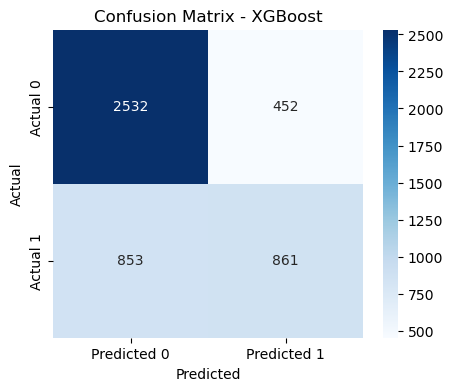


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2984
           1       0.66      0.50      0.57      1714

    accuracy                           0.72      4698
   macro avg       0.70      0.68      0.68      4698
weighted avg       0.71      0.72      0.71      4698



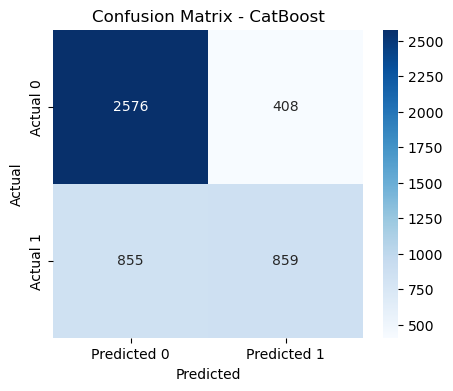


Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2984
           1       0.68      0.50      0.58      1714

    accuracy                           0.73      4698
   macro avg       0.71      0.68      0.69      4698
weighted avg       0.72      0.73      0.72      4698

[LightGBM] [Info] Number of positive: 6715, number of negative: 12077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357333 -> initscore=-0.586959
[LightGBM] [Info] Start training from score -0.586959


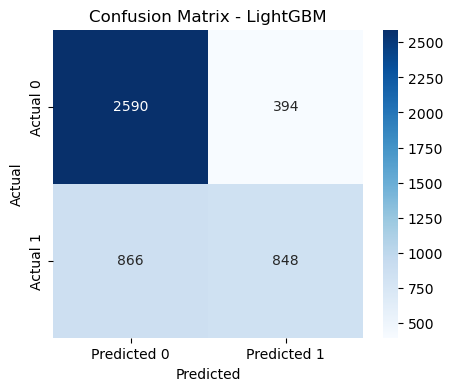


Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      2984
           1       0.68      0.49      0.57      1714

    accuracy                           0.73      4698
   macro avg       0.72      0.68      0.69      4698
weighted avg       0.73      0.73      0.72      4698


===== Results for RobustScaler =====


c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:46:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


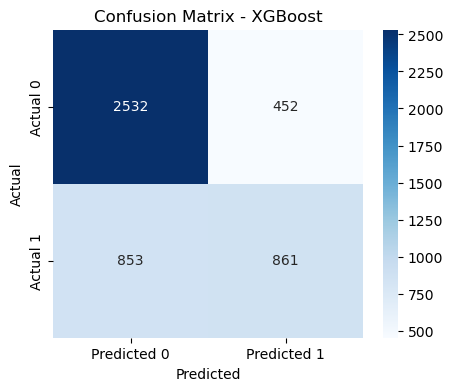


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2984
           1       0.66      0.50      0.57      1714

    accuracy                           0.72      4698
   macro avg       0.70      0.68      0.68      4698
weighted avg       0.71      0.72      0.71      4698



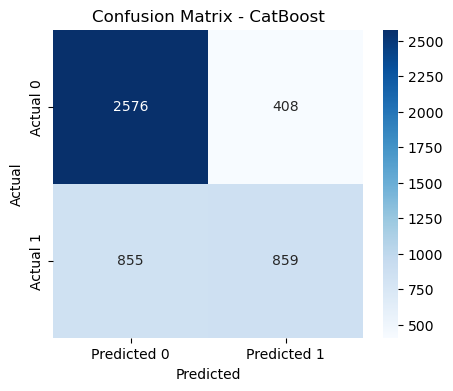


Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2984
           1       0.68      0.50      0.58      1714

    accuracy                           0.73      4698
   macro avg       0.71      0.68      0.69      4698
weighted avg       0.72      0.73      0.72      4698

[LightGBM] [Info] Number of positive: 6715, number of negative: 12077
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357333 -> initscore=-0.586959
[LightGBM] [Info] Start training from score -0.586959


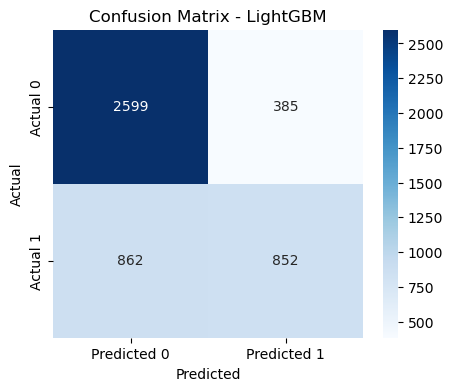


Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2984
           1       0.69      0.50      0.58      1714

    accuracy                           0.73      4698
   macro avg       0.72      0.68      0.69      4698
weighted avg       0.73      0.73      0.72      4698


===== Results for MinMaxScaler =====


c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:46:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


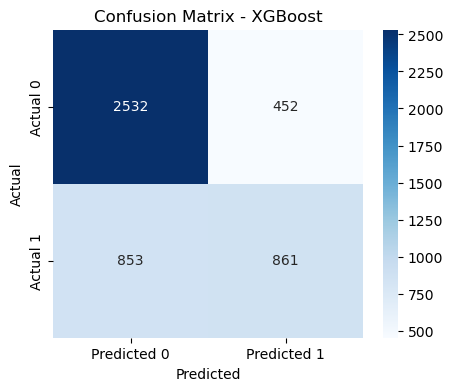


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2984
           1       0.66      0.50      0.57      1714

    accuracy                           0.72      4698
   macro avg       0.70      0.68      0.68      4698
weighted avg       0.71      0.72      0.71      4698



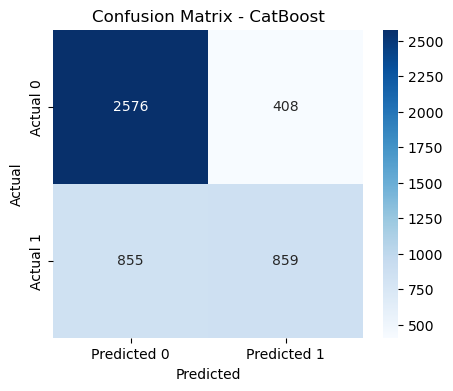


Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2984
           1       0.68      0.50      0.58      1714

    accuracy                           0.73      4698
   macro avg       0.71      0.68      0.69      4698
weighted avg       0.72      0.73      0.72      4698

[LightGBM] [Info] Number of positive: 6715, number of negative: 12077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357333 -> initscore=-0.586959
[LightGBM] [Info] Start training from score -0.586959


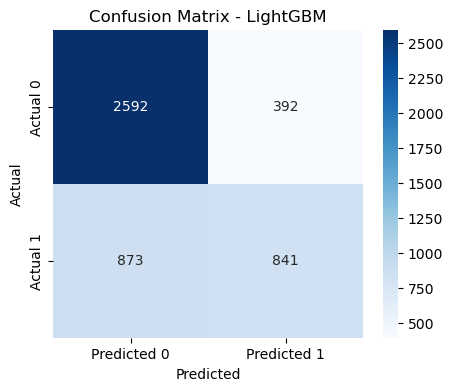


Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      2984
           1       0.68      0.49      0.57      1714

    accuracy                           0.73      4698
   macro avg       0.72      0.68      0.69      4698
weighted avg       0.72      0.73      0.72      4698


===== Results for MaxAbsScaler =====


c:\Users\Admin\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:46:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


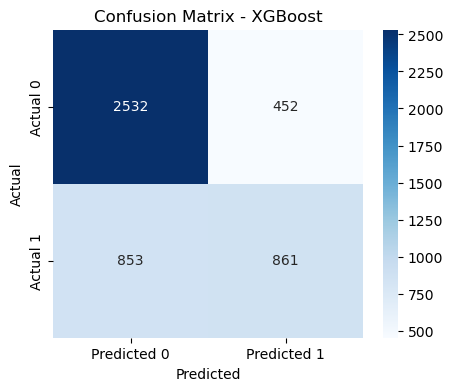


Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      2984
           1       0.66      0.50      0.57      1714

    accuracy                           0.72      4698
   macro avg       0.70      0.68      0.68      4698
weighted avg       0.71      0.72      0.71      4698



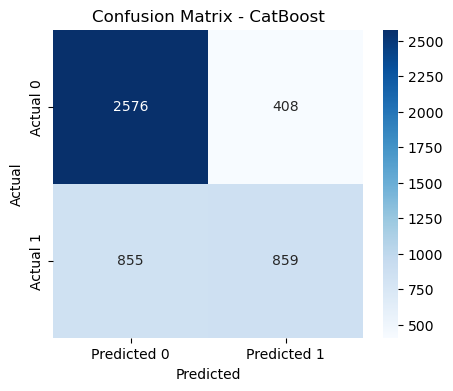


Classification Report for CatBoost:

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2984
           1       0.68      0.50      0.58      1714

    accuracy                           0.73      4698
   macro avg       0.71      0.68      0.69      4698
weighted avg       0.72      0.73      0.72      4698

[LightGBM] [Info] Number of positive: 6715, number of negative: 12077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 18792, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.357333 -> initscore=-0.586959
[LightGBM] [Info] Start training from score -0.586959


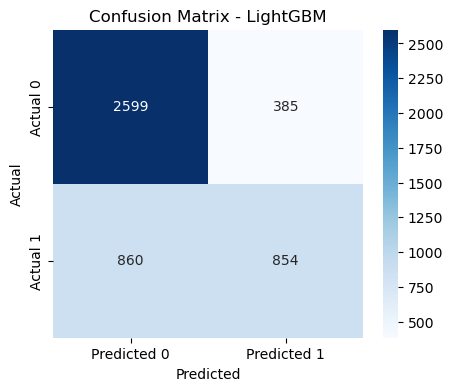


Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2984
           1       0.69      0.50      0.58      1714

    accuracy                           0.73      4698
   macro avg       0.72      0.68      0.69      4698
weighted avg       0.73      0.73      0.72      4698



In [23]:
all_results = {}

for scaler_name, (X_train_scaled, X_test_scaled) in scaled_datasets.items():
    print(f"\n===== Results for {scaler_name} =====")
    results = train_and_evaluate_models(
        X_train_scaled, X_test_scaled, y_train, y_test
    )
    all_results[scaler_name] = results


To evaluate model performance, multiple data scaling techniques—RobustScaler, StandardScaler, MinMaxScaler, and MaxAbsScaler—were applied to the dataset. Each scaled dataset was passed through three baseline machine learning models: XGBoost, CatBoost, and LightGBM. Model performance was measured using accuracy scores and confusion matrices.

Across all scaling techniques, LightGBM consistently delivered higher accuracy compared to XGBoost and CatBoost. StandardScaler combined with LightGBM produced the most stable and reliable results, with balanced true positive and true negative predictions as observed in the confusion matrix. Based on comparative evaluation, StandardScaler was identified as the most suitable scaling technique, and LightGBM emerged as the best-performing model.